**Name:** *Muhammad Usman FAROOQ* and *Rohith*

**EID:** *mufarooq5* and

**Kaggle Team Name:** *Abelian Group*

At the end of the project turn it into a pip installable

# CS4487 - Course Project: Aerial Cactus Identification

## Goal
In this project, your goal is to train a classifier to predict whether an input image contains cactus.


## Methodology
You need to train classifiers using the training data, and then predict on the test data. You are free to choose the feature extraction method and classifier algorithm.  You are free to use methods that were not introduced in class.  You should probably do cross-validation to select a good parameters.


## Evaluation on Kaggle

You need to submit your test predictions to Kaggle for evaluation.  50% of the test data will be used to show your ranking on the live leaderboard.  After the assignment deadline, the remaining 50% will be used to calculate your final ranking. 

To submit to Kaggle you need to create an account, and use the competition invitation that will be posted on Canvas.

**Note:** You can only submit 2 times per day to Kaggle!



## Kaggle Notebooks

You can use Kaggle notebooks to run your code. This ipynb has also been uploaded to the Kaggle competition site. 

# Load the Data

The class labels `"1"` for images containing cactus and `"0"` for others.

To submit to Kaggle, you need to generate a Kaggle submission files, which is CSV file with the following format. `'id'` is the file name of the input image: 

<pre>
Id,Prediction
cactus_0181_18.jpg,1
Sinplanta.4365.jpg,0
...
</pre>

Here are two helpful functions for reading the data and writing the Kaggle submission file.

In [1]:
%matplotlib inline
import IPython.core.display         
# setup output image format (Chrome works best)
# IPython.core.display.set_matplotlib_formats("svg")
import matplotlib.pyplot as plt
import matplotlib
from numpy import *
from sklearn import *
from glob import glob
from scipy import stats
import csv
import os

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import csv
import fnmatch
import os
from glob import glob
import kaggle
import matplotlib.pyplot as plt
plt.style.use("ggplot")
random.seed(100)

# OpenCV Image Library
import cv2

# Create dataset folder
import shutil
import zipfile

# Import PyTorch
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torchvision
import torch.optim as optim

In [2]:
def read_train_data():
    cactus_imgs = glob("training_set/cactus/*")
    cactus_labels = ones(len(cactus_imgs), dtype=int)
    nocactus_imgs = glob("training_set/no_cactus/*")
    nocactus_labels = zeros(len(nocactus_imgs), dtype=int)

    train_X = cactus_imgs + nocactus_imgs
    train_Y = hstack((cactus_labels, nocactus_labels))
    return train_X, train_Y

def read_test_data():
    return glob("validation_set/*/*")

def write_csv_kaggle_sub(fname, X, Y):
    # fname = file name
    # X is a list with image names
    # Y is a list/array with class entries
    
    # header
    tmp = [['Id', 'Prediction']]
    
    # add ID numbers for each Y
    for x,y in zip(X, Y):
        tmp2 = [x, y]
        tmp.append(tmp2)
        
    # write CSV file
    with open(fname, 'w') as f:
        writer = csv.writer(f)
        writer.writerows(tmp)

# YOUR CODE and DOCUMENTATION HERE

In [3]:
train_X, train_Y = read_train_data()
print(train_X[0], train_Y[0])
print(train_X[15000], train_Y[15000])
print(len(train_X))

test_X = read_test_data()
print(test_X[0])
print(len(test_X))
print(os.path.basename(test_X[0]))

training_set/cactus\cactus_0028_0.jpg 1
training_set/no_cactus\Sinplanta.2677.jpg 0
17500
validation_set\cactus\cactus_0181_18.jpg
4000
cactus_0181_18.jpg


In [4]:
## Extract all files from Validation set into a single folder

#TODO: Only run this if the validation_set folder isn't there

testDirectory = "validation_set"
testZip = "validation_set.zip"

with zipfile.ZipFile(testZip) as zip_file:
    for member in zip_file.namelist():
        filename = os.path.basename(member)
#         skip the directories
        if not filename:
            continue

        # copy file
        source = zip_file.open(member)
        target = open(os.path.join(testDirectory, filename), "wb")
        with source, target:
            shutil.copyfileobj(source, target)
            


In [39]:
## Read the labels and names/paths of training images into a CSV
imageName = []
imageLabel = []
imagePath = []

for index, fileName in enumerate(train_X):
    if (fileName.startswith("training_set/cactus") or fileName.startswith("training_set/no_cactus")) and fileName.endswith(".jpg"):
#         if index < 15:
#             print(fileName.split("\\")[1])
        imageName.append(fileName.split("\\")[1])
        imageLabel.append(train_Y[index])
        imagePath.append(fileName)
            
print(len(imageName), len(imageLabel), len(set(imagePath)))

with open('training_set.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(len(imageLabel)):
        writer.writerow([imageName[i], imageLabel[i], imagePath[i]])

17500 17500 17500


In [40]:
## Read the labels and names/paths of test images into a CSV
imageName = []
imageLabel = []
imagePath = []

print(len(test_X))
for index, fileName in enumerate(test_X):
#     if index < 10:
#         print(fileName.split("\\"))
    if (fileName.startswith("validation_set\cactus") or fileName.startswith("validation_set\\cactus"))  and fileName.endswith(".jpg"):
        imageName.append(fileName.split("\\")[2])
        imageLabel.append(1)
        imagePath.append(fileName)
    elif (fileName.startswith("validation_set\no_cactus") or fileName.startswith("validation_set\\no_cactus")) and fileName.endswith(".jpg"):
        imageName.append(fileName.split("\\")[2])
        imageLabel.append(0)
        imagePath.append(fileName)
            
print(len(set(imageName)), len(imageLabel), len(set(imagePath)))
    
with open('validation_set.csv', 'w') as f:
    writer = csv.writer(f)
    for i in range(len(imageLabel)):
        writer.writerow([imageName[i], imageLabel[i], imagePath[i]])

4000
4000 4000 4000


In [41]:
## Turn CSVs into 
head = ['fileName','classValue', 'imagePath']
trainDF = pd.read_csv("training_set.csv", names = head, header = None)
testDF = pd.read_csv("validation_set.csv", names = head, header = None)

trainDF.head()

,fileName,classValue,imagePath
0,cactus_0028_0.jpg,1,training_set/cactus\cactus_0028_0.jpg
1,cactus_0028_1.jpg,1,training_set/cactus\cactus_0028_1.jpg
2,cactus_0028_10.jpg,1,training_set/cactus\cactus_0028_10.jpg
3,cactus_0028_101.jpg,1,training_set/cactus\cactus_0028_101.jpg
4,cactus_0028_104.jpg,1,training_set/cactus\cactus_0028_104.jpg


In [8]:
print("Training Size: {}".format(len(glob('training_set/*/*'))))
print("Validation Size: {}".format(len(glob('validation_set/*/*'))))

Training Size: 17500
Validation Size: 4000


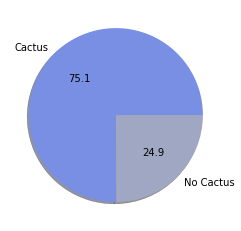

<Figure size 360x360 with 0 Axes>

In [42]:
# Counting the number of sample data for each class
%matplotlib inline
value_counts = trainDF.classValue.value_counts()
# TODO: CHOOSE SOME GOOD COLORS
plt.pie(value_counts, labels=['Cactus', 'No Cactus'], autopct='%1.1f', colors=['#788fe3', '#9fa7c2'], shadow=True)
plt.figure(figsize=(5,5))
plt.show()

# Setting up dataset/training data for Pytorch

In [43]:
# Data paths
trainingPath = 'training_set/'
validationPath = 'validation_set/'

In [ ]:
trainDF["directory"] = 

In [55]:
# Our own custom class for datasets
class CreateDataset(Dataset):
    def __init__(self, data, dataDirectory = './', transform=None):
        super().__init__()
        self.DF = data.values
        self.data_dir = data.imagePath
        self.transform = transform

    def __len__(self):
        return len(self.DF)
    
    def __getitem__(self, index):
        img_name, label, imagePath = self.DF[index]
        image = cv2.imread(imagePath)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [56]:
trainingTransforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((32,32)),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_data = CreateDataset(data=trainDF, dataDirectory=trainingPath, transform=trainingTransforms)

In [57]:
# Set Batch Size
batch_size = 64

# Percentage of training set to use as validation
valid_size = 0.2

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# Create Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=train_sampler)
valid_loader = DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler)

In [58]:
transforms_test = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((32,32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# creating test data
test_data = CreateDataset(data=testDF, dataDirectory=validationPath, transform=transforms_test)

# prepare the test loader
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

In [59]:
classes = [ 'No Cactus','Cactus']

In [60]:
def imshow(img):
    '''Helper function to un-normalize and display an image'''
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image and display
    plt.imshow(np.transpose(img, (1, 2, 0)))

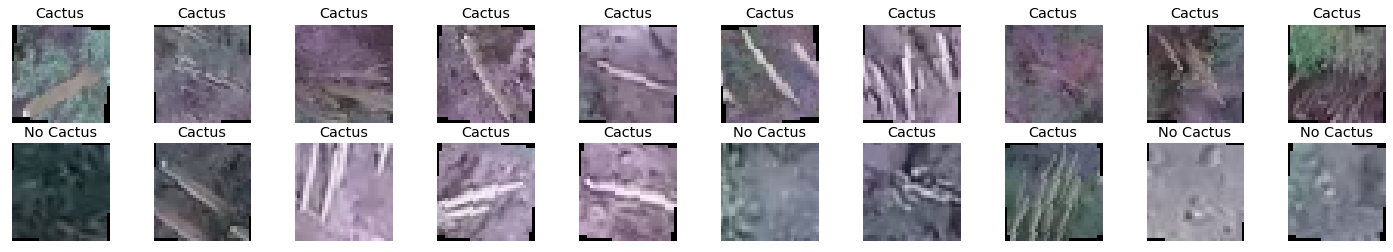

In [61]:
%matplotlib inline
# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
images = images.numpy() # convert images to numpy for display

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

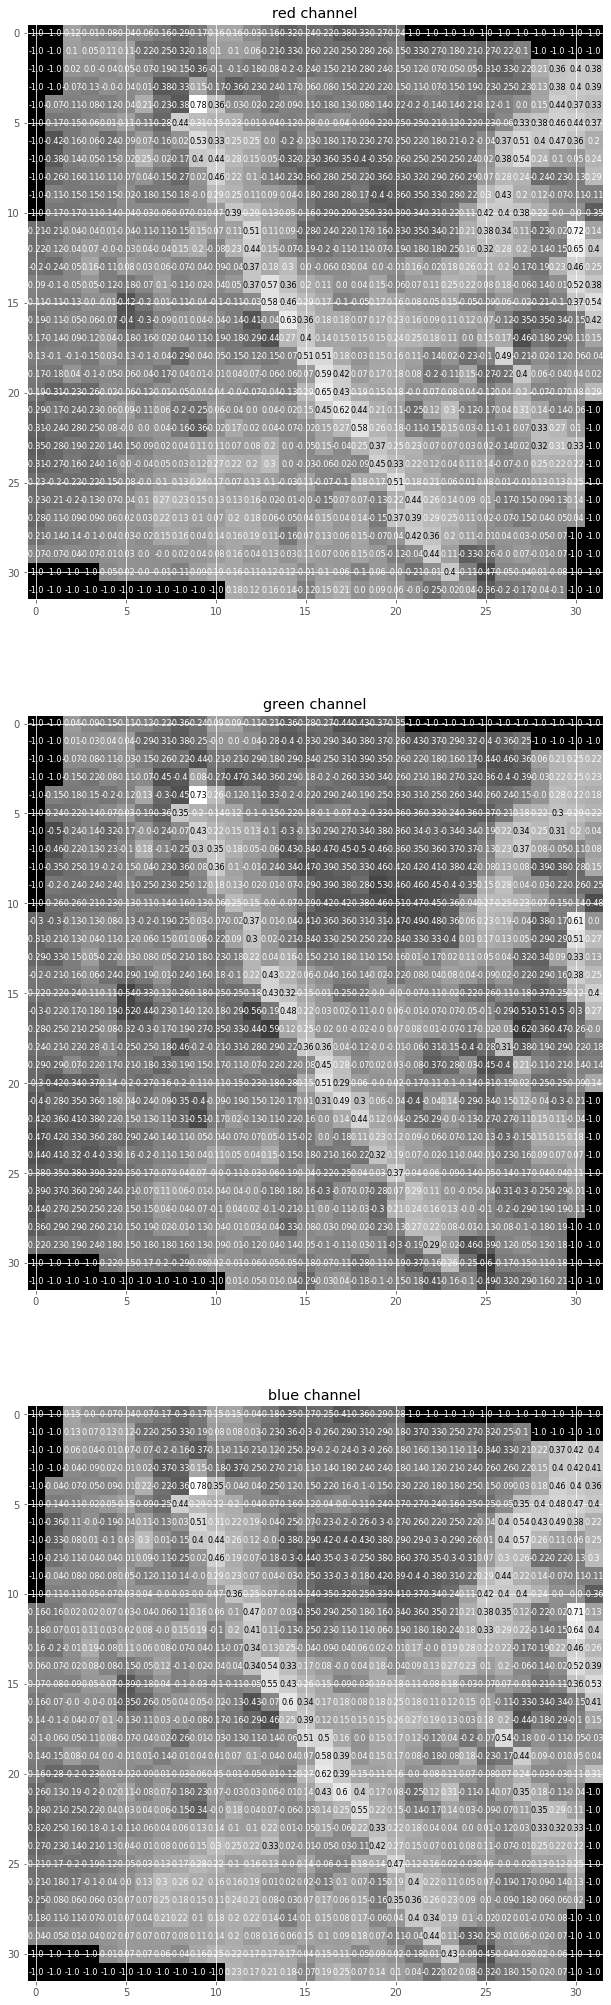

In [62]:
%matplotlib inline

rgb_img = np.squeeze(images[3])
channels = ['red channel', 'green channel', 'blue channel']

fig = plt.figure(figsize = (36, 36)) 
for idx in np.arange(rgb_img.shape[0]):
    ax = fig.add_subplot(3, 1, idx + 1)
    img = rgb_img[idx]
    ax.imshow(img, cmap='gray')
    ax.set_title(channels[idx])
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            val = round(img[x][y],2) if img[x][y] !=0 else 0
            ax.annotate(str(val), xy=(y,x),
                    horizontalalignment='center',
                    verticalalignment='center', size=8,
                    color='white' if img[x][y]<thresh else 'black')

# CNN - Paper

In [ ]:
### https://github.com/bollakarthikeya/LeNet-5-PyTorch/blob/master/lenet5_cpu.py
### 

class LeNet5CNN(nn.Module):
    def __init__(self):
        super(LeNet5CNN, self).__init__()
        # Convolution (In LeNet-5, 32x32 images are given as input. Hence padding of 2 is done below)
        self.conv1 = torch.nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1, padding=2, bias=True)
        # Max-pooling
        self.max_pool_1 = torch.nn.MaxPool2d(kernel_size=2)
        # Convolution
        self.conv2 = torch.nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0, bias=True)
        # Max-pooling
        self.max_pool_2 = torch.nn.MaxPool2d(kernel_size=2)
        # Fully connected layer
        self.fc1 = torch.nn.Linear(16*5*5, 120)   # convert matrix with 16*5*5 (= 400) features to a matrix of 120 features (columns)
        self.fc2 = torch.nn.Linear(120, 84)       # convert matrix with 120 features to a matrix of 84 features (columns)
        self.fc3 = torch.nn.Linear(84, 10)        # convert matrix with 84 features to a matrix of 10 features (columns)
        
    def forward(self, x):
        x = F.relu(self.conv1(x))  
        # max-pooling with 2x2 grid
        x = self.max_pool_1(x)
        # convolve, then perform ReLU non-linearity
        x = F.relu(self.conv2(x))
        # max-pooling with 2x2 grid
        x = self.max_pool_2(x)
        # first flatten 'max_pool_2_out' to contain 16*5*5 columns
        # read through https://stackoverflow.com/a/42482819/7551231
        x = x.view(-1, 16*5*5)
        # FC-1, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc1(x))
        # FC-2, then perform ReLU non-linearity
        x = torch.nn.functional.relu(self.fc2(x))
        # FC-3
        x = self.fc3(x)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return x, logits, probs

In [ ]:


class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2),
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1),
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

In [ ]:
%%time

In [23]:
# write your predictions on the test set
dummy_test_X = [os.path.basename(x) for x in test_X]
test_Y = random.randint(2, size=len(test_X))

write_csv_kaggle_sub("my_submission.csv", dummy_test_X, test_Y)